In [1]:
import torch
import numpy as np
from PIL import Image
from diffusers import AutoPipelineForInpainting

pipeline = AutoPipelineForInpainting.from_pretrained(
    "runwayml/stable-diffusion-inpainting", 
    torch_dtype=torch.float16, 
    variant="fp16",
    safety_checker=None
).to('cuda')
pipeline.enable_xformers_memory_efficient_attention()
pipeline.set_progress_bar_config(disable=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/home/soroush/.venv/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/soroush/.venv/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/home/soroush/.venv/lib/python3.11/site-packages/diffusers/models/vq_model.py:20: FutureWarning: `VQEncoderOutput` is deprecated and will be removed in version 0.31. Importing `VQEncoderOutput` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoder

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
def zoom_out(image, mask_width=10):
    resized_image = image.resize((image.height - 2 * mask_width, image.width - 2 * mask_width))
    blank = np.zeros_like(image)
    blank[mask_width:-mask_width, mask_width:-mask_width] = resized_image
    resized_image = Image.fromarray(blank)
    
    mask = np.ones_like(image) * 255
    mask[mask_width:-mask_width, mask_width:-mask_width] = 0
    mask = Image.fromarray(mask)
    return resized_image.convert('RGB'), mask

def rotate(image, angle=10):
    rotated_image = image.rotate(angle, expand=False)
    mask = Image.fromarray(np.ones_like(frames[0]) * 255)
    mask = mask.rotate(10, expand=False)
    mask = Image.fromarray(255 - np.array(mask))
    return rotated_image.convert('RGB'), mask

def move(image, width, direction):
    temp = np.array(image)
    mask = np.zeros_like(temp)
    if direction == 'top':
        temp = np.pad(temp, ((width, 0), (0, 0), (0, 0)))
        temp = temp[:image.height]
        mask[:width] = 255
    elif direction == 'bottom':
        temp = np.pad(temp, ((0, width), (0, 0), (0, 0)))
        temp = temp[-image.height:]
        mask[-width:] = 255
    elif direction == 'left':
        temp = np.pad(temp, ((0, 0), (width, 0), (0, 0)))
        temp = temp[:, :image.width]
        mask[:, :width] = 255
    elif direction == 'right':
        temp = np.pad(temp, ((0, 0), (0, width), (0, 0)))
        temp = temp[:, -image.width:]
        mask[:, -width:] = 255
    return Image.fromarray(temp).convert('RGB'), Image.fromarray(mask)

def inpaint(image, mask):
    img = np.array(curr)
    msk = np.array(mask)[..., 0]
    img = cv2.inpaint(img, msk, 3, cv2.INPAINT_NS)
    return Image.fromarray(img)

In [41]:
from PIL import Image
import cv2
from tqdm.notebook import tqdm
from diffusers.utils import load_image, make_image_grid


duration = 10
fps = 15
n = duration * fps
init_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")
frames = [init_image]
generator = torch.Generator("cuda").manual_seed(7)

for _ in tqdm(range(duration * fps)):
    curr, mask = zoom_out(frames[-1], 10)
    # curr = inpaint(curr, mask)
    img = pipeline(
        prompt='a panaromic photo of a mountain in the middle of the jungle with tall trees in a sunny day, high quality, 4k', 
        negative_prompt='blurry, fuzzy, low quality, unstable, poor details',
        image=curr, 
        mask_image=mask, 
        generator=generator,
        num_inference_steps=50,
        guidance_scale=6,
        strength=.99
    ).images[0]
    mask = np.array(mask) // 255
    curr = Image.fromarray(mask * img + (1 - mask) * curr)
    frames += [curr]

  0%|          | 0/150 [00:00<?, ?it/s]

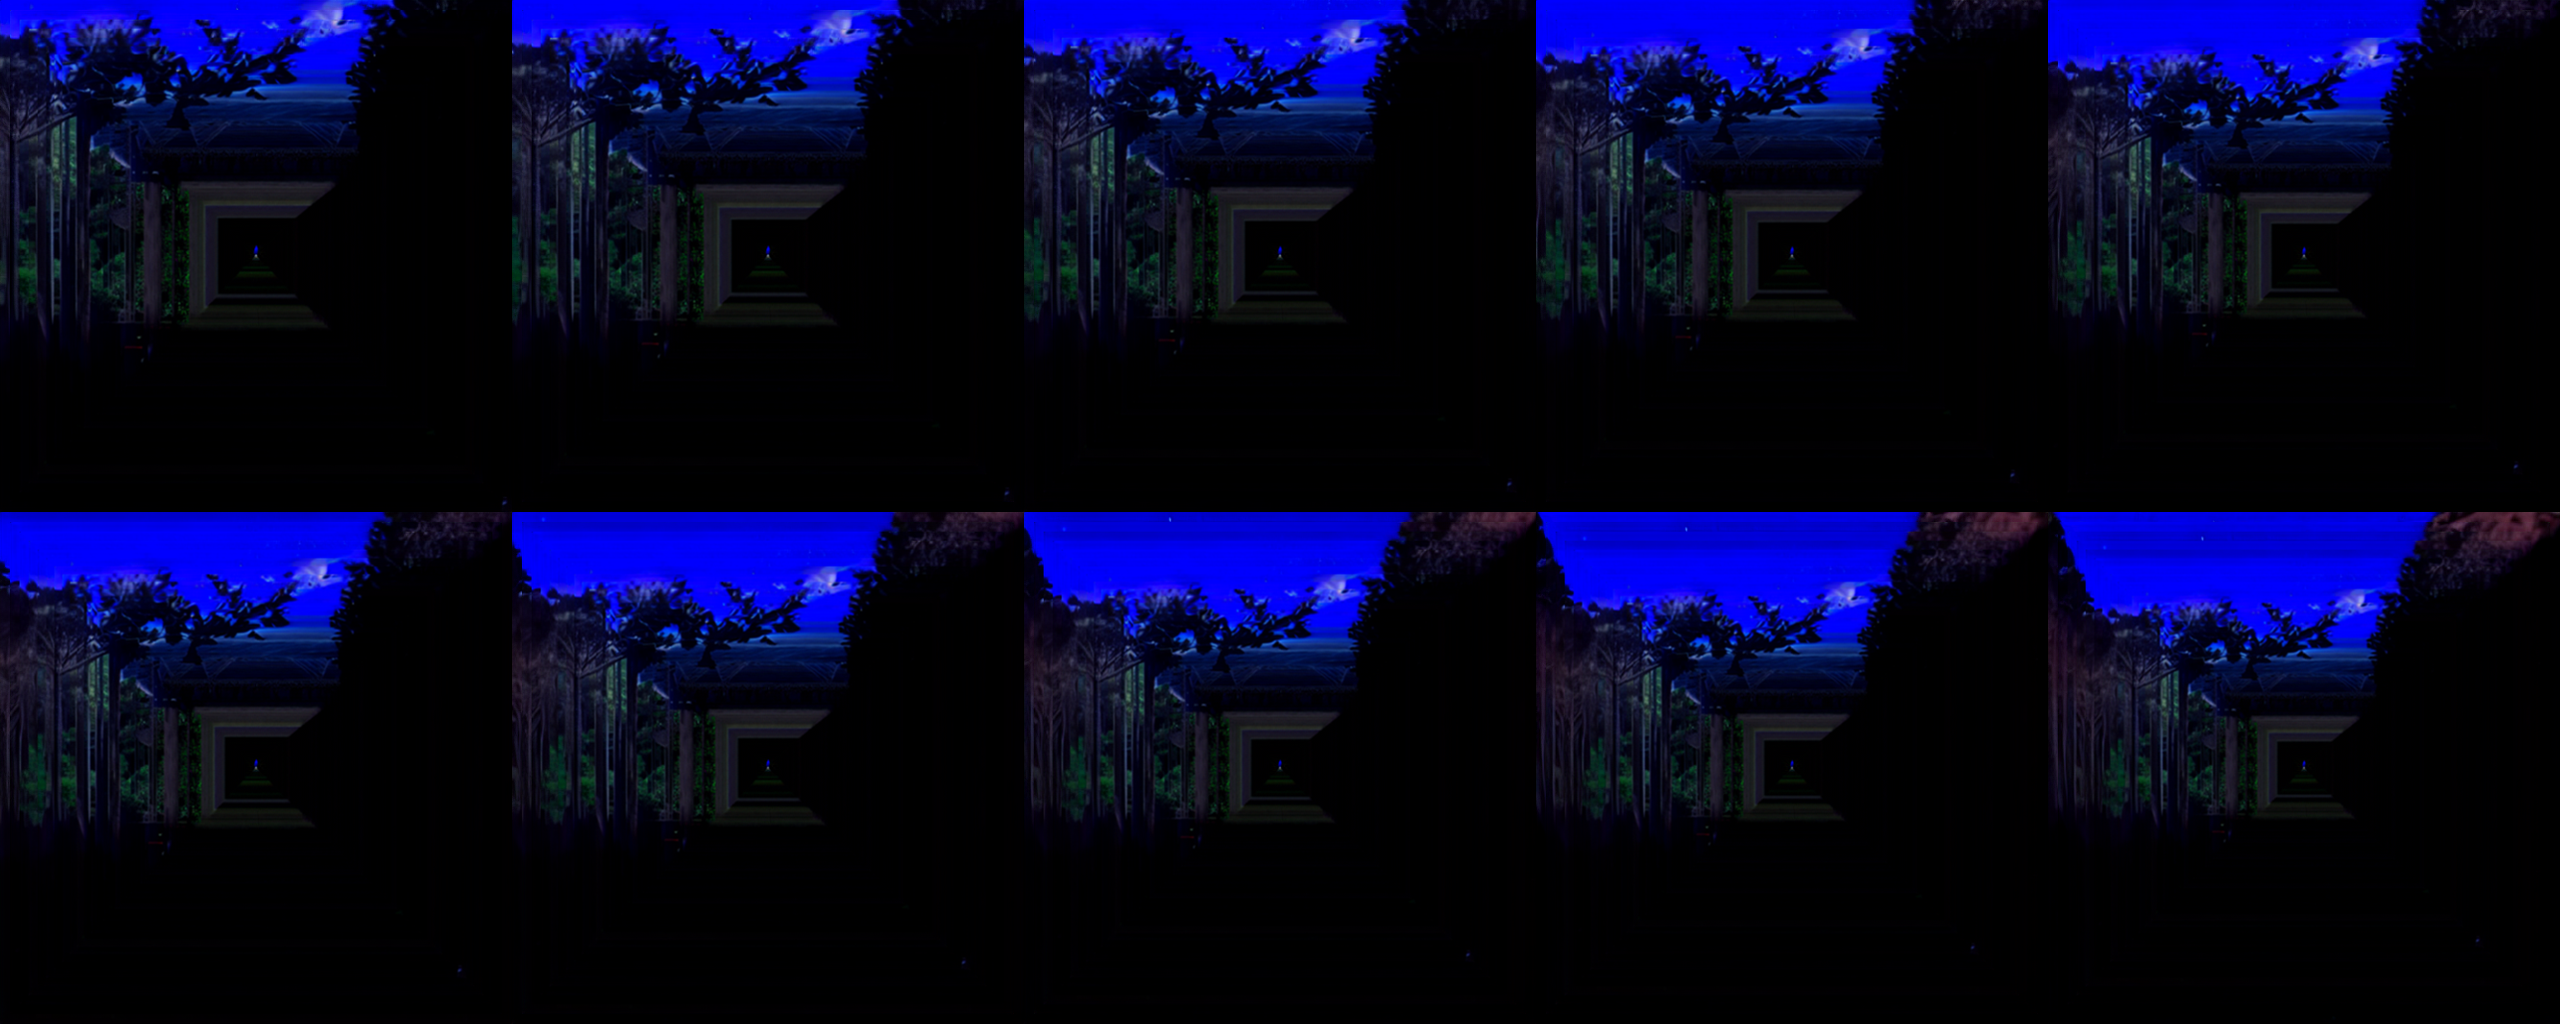

In [44]:
make_image_grid(frames[-10:], rows=2, cols=5)

In [43]:
import cv2

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # For MP4
video_writer = cv2.VideoWriter(
    'zoom.mp4', fourcc, fps, (512, 512)
)
for frame in frames + frames[::-1]:
    frame = np.array(frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    video_writer.write(frame)
video_writer.release()